---
---
---
## **4. Preprocesamiento**
---
---
---

---
---
### **4.1. Tratamiento de los valores outliers**
---
---

---
---
### **4.2. Tratamiento de los valores nulos y codificación de las variables**
---
---

In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Función de preprocesamiento
def preprocess_data(df):
    # 1. Eliminar columnas irrelevantes
    df.drop(columns=['health_insurance'], inplace=True)

    # 2. Asignar 'Missing' a columnas relacionadas con estado laboral
    df[['employment_industry', 'employment_occupation']] = df[['employment_industry', 'employment_occupation']].mask(
        df['employment_status'].isin(['Not in Labor Force', 'Unemployed']), 'Missing'
    )

    # 3. Imputación personalizada
    # (A) Variables ordinales: Añadir categoría 'Missing' como nueva clase será el valor máximo de categoría.
    ordinal_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                    'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                    'opinion_seas_sick_from_vacc']

    # Imputar valores faltantes en columnas ordinales con el valor máximo de la categoría + 1
    for col in ordinal_cols:
        # Asegurarse de que la columna es numérica
        df[col] = pd.to_numeric(df[col], errors='coerce')
        max_value = df[col].max()  # Obtiene el valor máximo actual de la columna
        df[col] = df[col].fillna(max_value + 1) # Imputa los valores faltantes con max_value + 1

    # Orden explícito para las columnas ordinales_str
    ordinal_order = {
        # No hay valores nulos en age_group.
        'age_group': ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'],
        # Categoría missing como educación media.
        'education': ['< 12 Years', '12 Years','Missing', 'Some College', 'College Graduate'],
        # Categoría missing por encima de pobreza y debajo de "encima de pobreza"
        'income_poverty': ['Below Poverty', 'Missing', '<= $75,000, Above Poverty', '> $75,000']
    }

    ordinal_keys = list(ordinal_order.keys())
    for col in ["education", "income_poverty"]:
        df[col] = df[col].fillna("Missing")
        
    ordinal_encoder = OrdinalEncoder(categories=[ordinal_order[col] for col in ordinal_keys])
    df[ordinal_keys] = ordinal_encoder.fit_transform(df[ordinal_keys])

    # (B) Variables binarias: Imputación supervisada con RandomForest
    binary_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
                'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1',
                'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'sex', 'marital_status', 'rent_or_own']

    # Iterar por cada columna binaria para imputar
    for col in binary_cols:
        is_null = df[col].isnull()  # Identificar valores faltantes
        if is_null.sum() > 0:
            # Convertir todas las columnas categóricas (incluidas las binarias) a valores numéricos
            df_encoded = df.copy()

            for c in df_encoded.select_dtypes(include='object').columns:
                df_encoded[c], _ = pd.factorize(df_encoded[c])

            # Separar datos de entrenamiento y prueba
            train_data = df_encoded.loc[~is_null, :]  # Filas sin valores nulos
            test_data = df_encoded.loc[is_null, :]    # Filas con valores nulos

            # Entrenar modelo RandomForest
            clf = RandomForestClassifier(random_state=42)
            clf.fit(train_data.drop(columns=[col]), train_data[col])

            # Predecir valores faltantes
            df.loc[is_null, col] = clf.predict(test_data.drop(columns=[col]))
    
    # Diccionarios de mapeo para cada columna binaria de tipo object
    mappings = {
        'sex': {'Male': 0, 'Female': 1},
        'marital_status': {'Not Married': 0, 'Married': 1},
        'rent_or_own': {'Own': 0, 'Rent': 1}
    }

    # Aplicar los mapeos manuales
    for col, mapping in mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)
    
    # (C) Variables nominales: Añadir categoría 'Missing'
    nominal_cols = ['race', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
    for col in nominal_cols:
        df[col] = df[col].fillna("Missing")

    # Codificar variables nominales con OneHotEncoder
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    nominal_encoded = one_hot_encoder.fit_transform(df[nominal_cols])  # Ahora genera una matriz densa

    # Crear DataFrame con las columnas codificadas
    nominal_encoded_df = pd.DataFrame(
        nominal_encoded,
        columns=one_hot_encoder.get_feature_names_out(nominal_cols),  # Nombres de las columnas generadas
        index=df.index  # Mantener el índice original del DataFrame
    )

    # (D) Variables numéricas: Imputación con KNN
    numeric_cols = ['household_adults', 'household_children']
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Redondear los valores imputados al entero más cercano
    df[numeric_cols] = df[numeric_cols].round(0).astype(int)

    # Concatenar las variables nominales codificadas con el resto del DataFrame
    df.drop(columns=nominal_cols, inplace=True)
    df = pd.concat([df, nominal_encoded_df], axis=1)

    return df

In [3]:
# Cargar datos
data = pd.read_csv('Data/training_set_features.csv')
labels = pd.read_csv('Data/training_set_labels.csv', index_col="respondent_id")

In [4]:
# Dividir datos antes del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
# Preprocesar X_train y X_test
X_train_preprocessed = preprocess_data(X_train.copy())
X_test_preprocessed = preprocess_data(X_test.copy())

# Asegurar que 'respondent_id' sea el índice
X_train_preprocessed.set_index('respondent_id', inplace=True)
X_test_preprocessed.set_index('respondent_id', inplace=True)

# Guardar los datos preprocesados
X_train_preprocessed.to_csv('Data/preprocessed_X_train.csv', index=True)
X_test_preprocessed.to_csv('Data/preprocessed_X_test.csv', index=True)
y_train.to_csv('Data/preprocessed_y_train.csv', index=True)
y_test.to_csv('Data/preprocessed_y_test.csv', index=True)

In [6]:
# Cargar el conjunto de prueba externo y preprocesar
test_set_features = pd.read_csv("Data/test_set_features.csv")
test_set_preprocessed = preprocess_data(test_set_features.copy())

# Guardar el conjunto de prueba preprocesado
test_set_preprocessed.to_csv("Data/preprocessed_test_set_features.csv", index=False)

In [7]:
print(X_train_preprocessed.isnull().sum())

h1n1_concern                      0
h1n1_knowledge                    0
behavioral_antiviral_meds         0
behavioral_avoidance              0
behavioral_face_mask              0
                                 ..
employment_occupation_vlluhbov    0
employment_occupation_xgwztkwe    0
employment_occupation_xqwwgdyp    0
employment_occupation_xtkaffoo    0
employment_occupation_xzmlyyjv    0
Length: 95, dtype: int64


In [8]:
# 1. Dimensiones del dataset
print("Dimensiones del dataset:")
print(f"Filas: {X_train_preprocessed.shape[0]}, Columnas: {X_train_preprocessed.shape[1]}")

# 2. Información del dataset
print("\nInformación general del dataset:")
print(X_train_preprocessed.info())

# 3. Valores faltantes
print("\nValores faltantes por columna (porcentaje):")
missing_values = X_train_preprocessed.isna().mean() * 100
print(missing_values[missing_values > 0])

# 4. Estadísticas descriptivas
print("\nEstadísticas descriptivas del dataset:")
print(X_train_preprocessed.describe())

# 5. Distribución de las variables categóricas (opcional)
print("\nDistribución de algunas variables categóricas:")
categorical_cols = [col for col in X_train_preprocessed.columns if X_train_preprocessed[col].dtype == 'object']
for col in categorical_cols:
    print(f"\nDistribución de '{col}':")
    print(X_train_preprocessed[col].value_counts(normalize=True) * 100)

Dimensiones del dataset:
Filas: 21365, Columnas: 95

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 21365 entries, 12230 to 467
Data columns (total 95 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   h1n1_concern                          21365 non-null  float64
 1   h1n1_knowledge                        21365 non-null  float64
 2   behavioral_antiviral_meds             21365 non-null  float64
 3   behavioral_avoidance                  21365 non-null  float64
 4   behavioral_face_mask                  21365 non-null  float64
 5   behavioral_wash_hands                 21365 non-null  float64
 6   behavioral_large_gatherings           21365 non-null  float64
 7   behavioral_outside_home               21365 non-null  float64
 8   behavioral_touch_face                 21365 non-null  float64
 9   doctor_recc_h1n1                      21365 non-null  float64
 10 


Matriz de correlación:
                                h1n1_concern  h1n1_knowledge  \
h1n1_concern                        1.000000        0.053309   
h1n1_knowledge                      0.053309        1.000000   
behavioral_antiviral_meds           0.089588       -0.013678   
behavioral_avoidance                0.224037        0.081366   
behavioral_face_mask                0.156342        0.029563   
...                                      ...             ...   
employment_occupation_vlluhbov      0.016686       -0.037347   
employment_occupation_xgwztkwe     -0.023634        0.017092   
employment_occupation_xqwwgdyp      0.002971       -0.032835   
employment_occupation_xtkaffoo     -0.016693        0.070881   
employment_occupation_xzmlyyjv     -0.010614        0.031560   

                                behavioral_antiviral_meds  \
h1n1_concern                                     0.089588   
h1n1_knowledge                                  -0.013678   
behavioral_antiviral_med

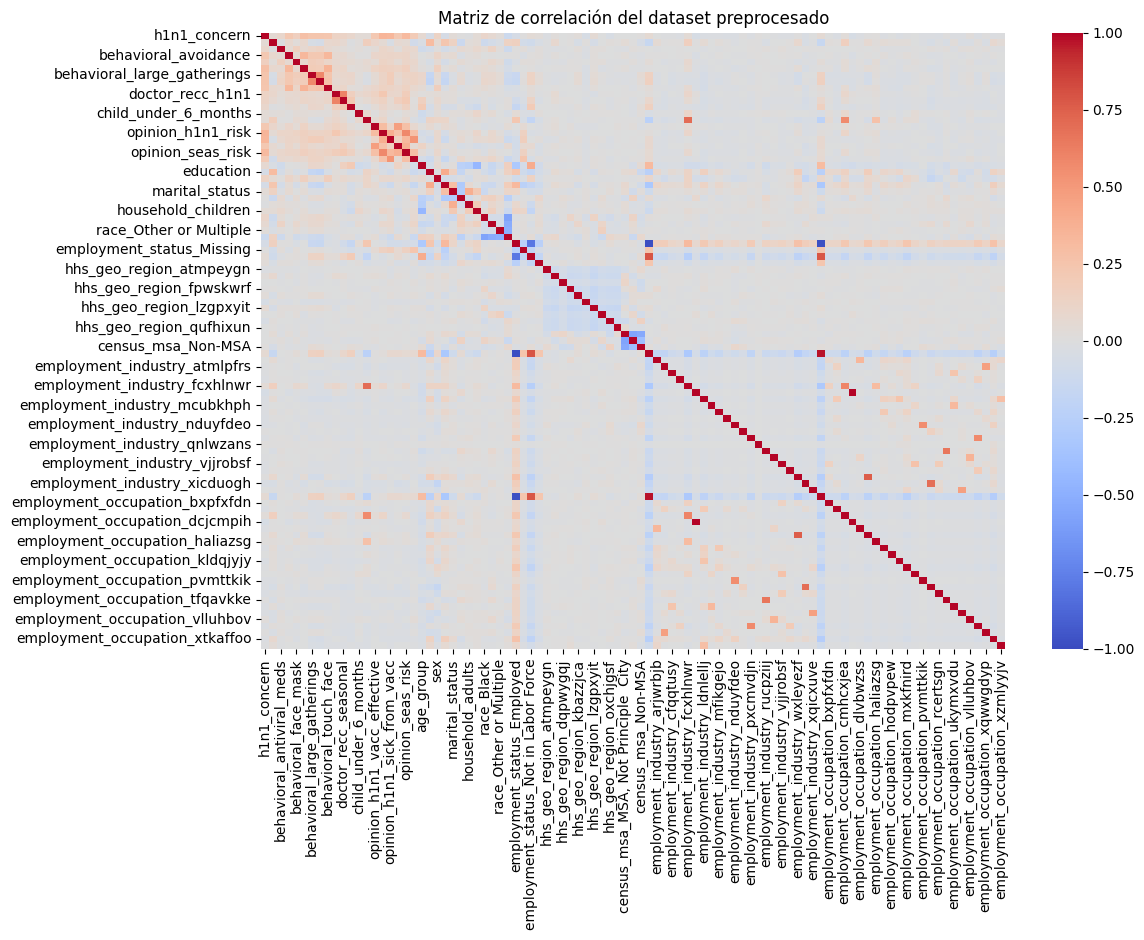

In [9]:
# 6. Correlación entre variables (opcional)
print("\nMatriz de correlación:")
correlation_matrix = X_train_preprocessed.corr()
print(correlation_matrix)

# Visualización opcional de correlaciones altas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlación del dataset preprocesado")
plt.show()